## RQ4: How to predict ratings from review text?

#### We considered the ratings and text review attributes from both genres and implemented a model to predict the appropriate ratings from respective text reviews of a book from both genres

### Importing the required libraries

In [46]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score


import pandas as pd
import datetime
import re
import time
import matplotlib.pyplot as plt
import seaborn as sn

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

### Loading the Comics and Graphics dataset

In [47]:
books_review_comics_df = pd.read_json('books_review_comics_final.json')

In [48]:
comics_review_text = books_review_comics_df[['review_text']]

### Performing the required preprocessing

In [49]:
def clean_data(df):
    total_time = 0
    start = time.time()
    
    review = pd.DataFrame()
    #combine title, abstract and full_literature to text column
    review['text'] = df['review_text']
    
    #convert text to lower case
    review['text']  = review['text'].str.lower()
    
    #remove punctuations
    #remove all non alphabetic characters
    regex_1 = re.compile(r'[^a-zA-Z]')
    review['text'] = pd.Series(review['text']).str.replace(regex_1, ' ')
    
    #reduce multi-space to single space
    regex_2 = re.compile(r' +')
    review['text'] = pd.Series(review['text']).str.replace(regex_2,' ')
   
    stop = time.time()
    duration = stop-start
    total_time = total_time + duration
    time_taken = str(datetime.timedelta(seconds=total_time))    
    print("Time taken/file :",duration)
    print("Total duration :",time_taken)
    
    return review

In [50]:
comics_review_text = clean_data(comics_review_text)

Time taken/file : 15.913562297821045
Total duration : 0:00:15.913562


### Displaying the respective ratings and text reviews of books

In [51]:
comics_review_text['rating'] = books_review_comics_df[['rating']]

In [52]:
comics_review_text.head()

,text,rating
0,sherlock holmes and the vampires of london rel...,3
1,i ve never really liked spider man i am howeve...,4
2,i ve been waiting so long for this i first stu...,5
3,the only thing more entertaining than this boo...,4
4,this wasn t my favourite black butler book i w...,3


### Checking the shape of the attribute

In [53]:
comics_review_text.shape

(330052, 2)

### splitting the samples into train and test

In [55]:
rev_samp = comics_review_text.sample(n = 330052, random_state = 42)
train = rev_samp[0:225000]
test = rev_samp[225000:]

### checking the shape of train and test splits

In [56]:
train.shape, test.shape

((225000, 2), (105052, 2))

### Visualizing the text and ratings of a particular books 

#### checking for skewing between ratings

,text,rating
67350,i read it quickly i did not know it was a trip...,2
159209,interesting while the race in the comic is a m...,4
132513,this graphic novel literally took me about a h...,4
119328,my future brother in law was moving and handed...,3
109789,when written well damian is an interesting cha...,4


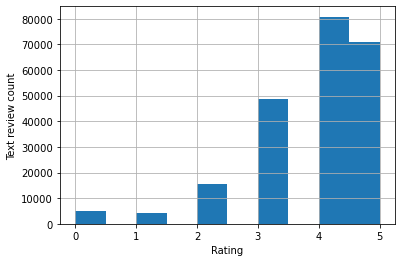

In [57]:
plt.ylabel('Text review count')
plt.xlabel('Rating')
train = train[['text', 'rating']]
train['rating'].hist();train.head()



### Creating the dummies for ratings using one-hot encoding

In [58]:
train = pd.get_dummies(train, columns = ['rating'])
train.head()

,text,rating_0,rating_1,rating_2,rating_3,rating_4,rating_5
67350,i read it quickly i did not know it was a trip...,0,0,1,0,0,0
159209,interesting while the race in the comic is a m...,0,0,0,0,1,0
132513,this graphic novel literally took me about a h...,0,0,0,0,1,0
119328,my future brother in law was moving and handed...,0,0,0,1,0,0
109789,when written well damian is an interesting cha...,0,0,0,0,1,0


### Now again checking for shape of train and test

In [59]:
test = test[['text', 'rating']]
test = pd.get_dummies(test, columns = ['rating'])
train.shape, test.shape

((225000, 7), (105052, 7))

In [60]:
train_samp = train.sample(frac = .1, random_state = 42)
test_samp = test.sample(frac = .1, random_state = 42)
train_samp.shape, test_samp.shape

((0, 7), (0, 7))

### Using TFIDF for word frequencies

In [39]:
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

### Considering NB features model

In [40]:
class NBFeatures(BaseEstimator):
    '''Class implementation of NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

### Taking logistic regression, NBfeatures into the pipeline

In [41]:
# Create pipeline using sklearn pipeline:
   
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

### Calculating the CV scores for ratings 1 to 5

In [42]:
class_names = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
scores = []
preds = np.zeros((len(test_samp), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train_samp[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train_samp['text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train_samp['text'].values, train_target)
    preds[:,i] = p.predict_proba(test_samp['text'].values)[:,1]

CV score for class rating_1 is 0.9823692364161466
CV score for class rating_2 is 0.9303692438914197
CV score for class rating_3 is 0.7867384743886952
CV score for class rating_4 is 0.6448615254817939
CV score for class rating_5 is 0.7419692293339505


In [43]:
print(tfidf)

TfidfVectorizer(max_features=2000)


### Calculating the accuracy of model

In [44]:
t = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.88      0.17      0.28        42
           2       0.45      0.24      0.31       112
           3       0.46      0.66      0.54       189
           4       0.59      0.67      0.63       147

    accuracy                           0.51       505
   macro avg       0.48      0.35      0.35       505
weighted avg       0.52      0.51      0.48       505



C:\Users\upend\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
